In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def load_and_prepare_data(filepath): 
    df = pd.read_csv(filepath)
    date_str, time_str = val.strip().split()
    if time_str == "24:00:00":
        month, day = map(int, date_str.split("/"))
        new_date = pd.Timestamp(year=2020, month=month, day=day) + pd.Timedelta(days=1)
        return new_date.replace(hour=0, minute=0, second=0)
    else:
        return pd.to_datetime(f"2020/{date_str} {time_str}", format="%Y/%m/%d %H:%M:%S")
    
    # Fix Date/Time column and add Month
    df['Date/Time'] = df['Date/Time'].apply(fix_datetime)
    df['Month'] = df['Date/Time'].dt.month
    df_data = df.drop(columns=["Date/Time"]).copy()
    df_data = df_data.apply(pd.to_numeric, errors='coerce')
    df_data['Month'] = df['Month']
    return df, df_data
    
def process_energy_data(csv_file, verbose=True):
    df = pd.read_csv(csv_file)
    
    # Print the column names for debugging if verbose is True.
    if verbose:
        print(f"\nColumns in {csv_file}:")
        print(df.columns.tolist())
    
    # Identify a Date/Time column (using any column that contains "Date" or "Time").
    date_time_col = None
    for col in df.columns:
        if "Date" in col or "Time" in col:
            date_time_col = col
            break
    
    if date_time_col is None:
        raise ValueError(f"No suitable Date/Time column found in {csv_file}")
    
    # Rename the detected Date/Time column for consistency.
    df.rename(columns={date_time_col: 'Date/Time'}, inplace=True)
    
    # Fix the 24:00:00 issue and convert the 'Date/Time' column.
    df['Date/Time'] = df['Date/Time'].str.replace(' 24:00:00', ' 00:00:00', regex=False)
    df['Date/Time'] = pd.to_datetime('2023 ' + df['Date/Time'], format='%Y %m/%d %H:%M:%S', errors='coerce')
    df.dropna(subset=['Date/Time'], inplace=True)
    return df

def process_metering_data(csv_file, verbose=True):
    """
    Reads the metered data and converts the date/time column to a datetime object.
    """
    df = pd.read_csv(csv_file)
    
    # Print the columns to debug header issues if verbose is True
    if verbose:
        print(f"\nColumns in {csv_file}:")
        print(df.columns.tolist())
    
    # Determine the timestamp column (rename if necessary)
    timestamp_col = None
    if 'Timestamp' in df.columns:
        timestamp_col = 'Timestamp'
    else:
        for col in df.columns:
            if "Date" in col or "Time" in col:
                timestamp_col = col
                df.rename(columns={col: 'Timestamp'}, inplace=True)
                break
        if timestamp_col is None:
            raise ValueError(f"No suitable Timestamp/Date column found in {csv_file}")

    # Convert the Timestamp column to datetime
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    df.dropna(subset=['Timestamp'], inplace=True)
    return df

def remap_simulation_name(sim_name, simulation_name_map=None):

    if simulation_name_map and sim_name in simulation_name_map:
        return simulation_name_map[sim_name]
    return sim_name

In [20]:
def breakdown_multifrequency_metrics(parent_folders, metered_csv, start_date, end_date, area, 
                                       simulation_name_map=None, print_metric="CVRMSE", 
                                       export_dir=None, verbose=True):
    import os
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    printer = print if verbose else lambda *args, **kwargs: None

    if export_dir:
        os.makedirs(export_dir, exist_ok=True)

    def compute_rmse(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return np.sqrt(mean_squared_error(resampled[met_col], resampled[sim_col]))

    def compute_cvrmse(df, freq_rule, sim_col, met_col):
        rmse = compute_rmse(df, freq_rule, sim_col, met_col)
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (rmse / mean_met) * 100

    def compute_mae(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return mean_absolute_error(resampled[met_col], resampled[sim_col])

    def compute_mape(df, freq_rule, sim_col, met_col):
        # Resample and sum the data
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        
        # Drop rows where `met_col` is 0 or NA
        resampled = resampled.dropna(subset=[met_col])  # Remove NA
        resampled = resampled[resampled[met_col] != 0]  # Remove zeros
        
        # Check if the filtered DataFrame is empty
        if resampled.empty:
            return None
        
        # Compute MAPE
        errors = np.abs((resampled[met_col] - resampled[sim_col]) / resampled[met_col])
        return np.mean(errors) * 100
    
    def compute_nmbe(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (resampled[sim_col] - resampled[met_col]).mean() / mean_met * 100

    sim_start, sim_end = pd.to_datetime(start_date), pd.to_datetime(end_date)

    df_met = process_metering_data(metered_csv, verbose)
    df_met['Timestamp'] = pd.to_datetime(df_met['Timestamp'])
    df_met = df_met[(df_met['Timestamp'] >= sim_start) & (df_met['Timestamp'] < sim_end)]
    df_met.sort_values('Timestamp', inplace=True)
    for metric in ['Electricity', 'Heating', 'Cooling']:
        df_met[f'{metric}_norm'] = df_met[f'Main {metric}'] / area
    df_met.set_index('Timestamp', inplace=True)

    freq_map = {'y':'YE','m':'ME','w':'W','d':'D','h':'h'}

    metric_funcs = {'RMSE':compute_rmse,'CVRMSE':compute_cvrmse,'MAE':compute_mae,'MAPE':compute_mape,'NMBE':compute_nmbe}
    metric_dfs = {metric:[] for metric in metric_funcs}

    for folder in parent_folders:
        for sim in os.listdir(folder):
            sim_path = os.path.join(folder, sim, 'eplusmtr.csv')
            if os.path.exists(sim_path):
                df_sim = process_energy_data(sim_path, verbose)
                df_sim['Date/Time'] = pd.to_datetime(df_sim['Date/Time'])
                df_sim = df_sim[(df_sim['Date/Time'] >= sim_start) & (df_sim['Date/Time'] < sim_end)]

                df_sim['Electricity_norm'] = (
                    df_sim['Electricity:Facility [J](Hourly)'] -
                    df_sim.get('Heating:Electricity [J](Hourly)',0)-
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Heating_norm'] = (
                    df_sim['DistrictHeatingWater:Facility [J](Hourly)'] +
                    df_sim.get('Heating:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Cooling_norm'] = (
                    df_sim['DistrictCooling:Facility [J](Hourly)'] +
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)

                merged = pd.merge(df_sim, df_met,left_on='Date/Time',right_index=True,suffixes=('_sim','_met'))
                merged.index = merged['Date/Time']
                sim_name = remap_simulation_name(sim, simulation_name_map)

                for metric, func in metric_funcs.items():
                    result_row = {'Simulation':sim_name}
                    for freq_label, freq_rule in freq_map.items():
                        for var in ['Electricity','Heating','Cooling']:
                            col_label = f'EUI$_{{{var}|{freq_label}}}$'
                            result_row[col_label] = func(merged,freq_rule,f'{var}_norm_sim',f'{var}_norm_met')
                    metric_dfs[metric].append(result_row)

    result_dfs = {}
    for metric, rows in metric_dfs.items():
        df = pd.DataFrame(rows).set_index('Simulation').round(2)
        result_dfs[metric] = df
        if metric.upper()==print_metric.upper():
            printer(f"\nComputed {metric.upper()} at multiple frequencies:", list(df.columns))

    return (result_dfs['CVRMSE'], result_dfs['RMSE'], result_dfs['MAE'], result_dfs['MAPE'], result_dfs['NMBE'])

In [21]:
def generate_eui_table(parent_folders, metered_csv, start_date, end_date, area, 
                       simulation_name_map=None, verbose=True):
    import os
    import pandas as pd

    # Define a printer that only prints if verbose is True.
    printer = print if verbose else lambda *args, **kwargs: None

    sim_start = pd.to_datetime(start_date)
    sim_end = pd.to_datetime(end_date)
    
    # --- Process Metered Data ---
    metered_results = None
    if metered_csv and os.path.exists(metered_csv):
        try:
            df_met = process_metering_data(metered_csv, verbose=verbose)
            df_met['Timestamp'] = pd.to_datetime(df_met['Timestamp'])
            df_met = df_met[(df_met['Timestamp'] >= sim_start) & (df_met['Timestamp'] < sim_end)]
            df_met.sort_values('Timestamp', inplace=True)
            # Normalize metered data (assuming the raw data are in appropriate energy units)
            df_met['Electricity_norm'] = df_met['Main Electricity'] / area
            df_met['Heating_norm']     = df_met['Main Heating'] / area
            df_met['Cooling_norm']     = df_met['Main Cooling'] / area
            df_met.set_index('Timestamp', inplace=True)
            metered_results = df_met
            printer(f"Metered data loaded for EUI calculation. Columns: {list(metered_results.columns)}")
        except Exception as e:
            printer(f"Error processing metered data: {e}")
            return None
    else:
        printer(f"Metered CSV file {metered_csv} not found.")
        return None

    # Resample metered data to annual totals.
    met_ann = metered_results.resample('YE').sum()
    if met_ann.empty:
        printer("No metered data available after resampling.")
        return None

    # Assume one annual period and extract values.
    met_elec = met_ann['Electricity_norm'].iloc[0]
    met_heat = met_ann['Heating_norm'].iloc[0]
    met_cool = met_ann['Cooling_norm'].iloc[0]
    met_eui  = met_elec + met_heat + met_cool

    # --- Process Simulation Data ---
    simulation_eui_list = []

    for parent_folder in parent_folders:
        printer(f"Processing simulation folders in: {parent_folder}")
        for child in os.listdir(parent_folder):
            full_path = os.path.join(parent_folder, child)
            if os.path.isdir(full_path):
                energy_file = None
                for file in os.listdir(full_path):
                    if file == "eplusmtr.csv":
                        energy_file = os.path.join(full_path, file)
                        break
                if energy_file:
                    printer(f"  Processing simulation: {energy_file}")
                    try:
                        df_sim = process_energy_data(energy_file, verbose=verbose)
                        df_sim['Date/Time'] = pd.to_datetime(df_sim['Date/Time'])
                        df_sim = df_sim[(df_sim['Date/Time'] >= sim_start) & (df_sim['Date/Time'] < sim_end)]
                        df_sim.sort_values('Date/Time', inplace=True)
                        # Compute normalized simulation values with conversion to appropriate units.
                        df_sim['Electricity_norm'] = (
                            df_sim['Electricity:Facility [J](Hourly)'] -
                            df_sim.get('Heating:Electricity [J](Hourly)', 0) -
                            df_sim.get('Cooling:Electricity [J](Hourly)', 0)
                        ) / (area * 3.6e6)
                        
                        df_sim['Heating_norm'] = (
                            df_sim['DistrictHeatingWater:Facility [J](Hourly)'] +
                            df_sim.get('Heating:Electricity [J](Hourly)', 0)
                        ) / (area * 3.6e6)
                        
                        df_sim['Cooling_norm'] = (
                            df_sim['DistrictCooling:Facility [J](Hourly)'] +
                            df_sim.get('Cooling:Electricity [J](Hourly)', 0)
                        ) / (area * 3.6e6)
                        
                        # Set index to Date/Time so that we can resample.
                        df_sim.set_index('Date/Time', inplace=True)
                        sim_ann = df_sim.resample('YE').sum()
                        if sim_ann.empty:
                            printer(f"    No annual data for simulation '{child}', skipping.")
                            continue
                        # Extract annual totals (assuming a single year within the filtered period)
                        sim_elec = sim_ann['Electricity_norm'].iloc[0]
                        sim_heat = sim_ann['Heating_norm'].iloc[0]
                        sim_cool = sim_ann['Cooling_norm'].iloc[0]
                        sim_eui  = sim_elec + sim_heat + sim_cool
                        
                        # Optionally remap the simulation folder name.
                        sim_display_name = remap_simulation_name(child, simulation_name_map)
                        simulation_eui_list.append({
                            'Simulation': sim_display_name,
                            'EUI$_{{Electricity|y}}$': round(sim_elec, 2),
                            'EUI$_{{Heating|y}}$': round(sim_heat, 2),
                            'EUI$_{{Cooling|y}}$': round(sim_cool, 2),
                            'EUI$_{{Total|y}}$':  round(sim_eui, 2)
                        })
                    except Exception as e:
                        printer(f"    Error processing simulation '{child}': {e}")
                else:
                    printer(f"  No eplusmtr.csv found in {full_path}")

    # Create a DataFrame for simulation results.
    if simulation_eui_list:
        sim_eui_df = pd.DataFrame(simulation_eui_list)
        sim_eui_df.set_index('Simulation', inplace=True)
    else:
        printer("No simulation data processed for EUI.")
        return None

    # --- Append Metered Data ---
    # Create a DataFrame row for the metered data using "Metered" as the index.
    metered_row = pd.DataFrame({
        'EUI$_{{Electricity|y}}$': [round(met_elec, 2)],
        'EUI$_{{Heating|y}}$': [round(met_heat, 2)],
        'EUI$_{{Cooling|y}}$': [round(met_cool, 2)],
        'EUI$_{{Total|y}}$':  [round(met_eui, 2)]
    }, index=["Metered"])

    # Combine simulation and metered data.
    final_eui_df = pd.concat([sim_eui_df, metered_row])
    
    printer(f"\nGenerated EUI Table. Columns: {list(final_eui_df.columns)}")
    return final_eui_df

group_order = ['Electricity', 'Heating', 'Cooling']
granularity_order = ['y', 'm', 'w', 'd', 'h']

def sort_key(col_name):
    # Extract group and granularity using split
    # Expected format: 'EUI$_{Group|Granularity}$'
    try:
        inner = col_name.split('$_{')[1].split('}$')[0]  # e.g., 'Electricity|y'
        group, granularity = inner.split('|')
        group_idx = group_order.index(group)
        granularity_idx = granularity_order.index(granularity)
        return (group_idx, granularity_idx)
    except Exception as e:
        # Put unknown formats at the end
        return (len(group_order), len(granularity_order))



In [22]:
def breakdown_multifrequency_metrics(parent_folders, metered_csv, start_date, end_date, area, 
                                       simulation_name_map=None, print_metric="CVRMSE", 
                                       export_dir=None, verbose=True):
    import os
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    printer = print if verbose else lambda *args, **kwargs: None

    if export_dir:
        os.makedirs(export_dir, exist_ok=True)

    def compute_rmse(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return np.sqrt(mean_squared_error(resampled[met_col], resampled[sim_col]))

    def compute_cvrmse(df, freq_rule, sim_col, met_col):
        rmse = compute_rmse(df, freq_rule, sim_col, met_col)
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (rmse / mean_met) * 100

    def compute_mae(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return mean_absolute_error(resampled[met_col], resampled[sim_col])

    def compute_mape(df, freq_rule, sim_col, met_col):
        # Resample and sum the data
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        
        # Drop rows where `met_col` is 0 or NA
        resampled = resampled.dropna(subset=[met_col])  # Remove NA
        resampled = resampled[resampled[met_col] != 0]  # Remove zeros
        
        # Check if the filtered DataFrame is empty
        if resampled.empty:
            return None
        
        # Compute MAPE
        errors = np.abs((resampled[met_col] - resampled[sim_col]) / resampled[met_col])
        return np.mean(errors) * 100
    
    def compute_nmbe(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (resampled[sim_col] - resampled[met_col]).mean() / mean_met * 100

    sim_start, sim_end = pd.to_datetime(start_date), pd.to_datetime(end_date)

    df_met = process_metering_data(metered_csv, verbose)
    df_met['Timestamp'] = pd.to_datetime(df_met['Timestamp'])
    df_met = df_met[(df_met['Timestamp'] >= sim_start) & (df_met['Timestamp'] < sim_end)]
    df_met.sort_values('Timestamp', inplace=True)
    for metric in ['Electricity', 'Heating', 'Cooling']:
        df_met[f'{metric}_norm'] = df_met[f'Main {metric}'] / area
    df_met.set_index('Timestamp', inplace=True)

    freq_map = {'y':'Y','m':'M','w':'W','d':'D','h':'h'}

    metric_funcs = {'RMSE':compute_rmse,'CVRMSE':compute_cvrmse,'MAE':compute_mae,'MAPE':compute_mape,'NMBE':compute_nmbe}
    metric_dfs = {metric:[] for metric in metric_funcs}

    for folder in parent_folders:
        for sim in os.listdir(folder):
            sim_path = os.path.join(folder, sim, 'eplusmtr.csv')
            if os.path.exists(sim_path):
                df_sim = process_energy_data(sim_path, verbose)
                df_sim['Date/Time'] = pd.to_datetime(df_sim['Date/Time'])
                df_sim = df_sim[(df_sim['Date/Time'] >= sim_start) & (df_sim['Date/Time'] < sim_end)]

                df_sim['Electricity_norm'] = (
                    df_sim['Electricity:Facility [J](Hourly)'] -
                    df_sim.get('Heating:Electricity [J](Hourly)',0)-
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Heating_norm'] = (
                    df_sim['DistrictHeatingWater:Facility [J](Hourly)'] +
                    df_sim.get('Heating:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Cooling_norm'] = (
                    df_sim['DistrictCooling:Facility [J](Hourly)'] +
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)

                merged = pd.merge(df_sim, df_met,left_on='Date/Time',right_index=True,suffixes=('_sim','_met'))
                merged.index = merged['Date/Time']
                sim_name = remap_simulation_name(sim, simulation_name_map)

                for metric, func in metric_funcs.items():
                    result_row = {'Simulation':sim_name}
                    for freq_label, freq_rule in freq_map.items():
                        for var in ['Electricity','Heating','Cooling']:
                            col_label = f'EUI$_{{{var}|{freq_label}}}$'
                            result_row[col_label] = func(merged,freq_rule,f'{var}_norm_sim',f'{var}_norm_met')
                    metric_dfs[metric].append(result_row)

    result_dfs = {}
    for metric, rows in metric_dfs.items():
        df = pd.DataFrame(rows).set_index('Simulation').round(2)
        result_dfs[metric] = df
        if metric.upper()==print_metric.upper():
            printer(f"\nComputed {metric.upper()} at multiple frequencies:", list(df.columns))

    return (result_dfs['CVRMSE'], result_dfs['RMSE'], result_dfs['MAE'], result_dfs['MAPE'], result_dfs['NMBE'])

parent_folders = ['2025-Apr15']
metered_csv = 'Metering.csv'
start_date = '2023-01-01'
end_date = '2024-01-01'
area = 8894


simulation_name_map = {
    "gh-Detailed-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_03Detailed",
    "gh-Detailed-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_03Detailed",
    "gh-Detailed-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_03Detailed",
    "gh-Ideal-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_01Ideal",
    "gh-Ideal-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_01Ideal",
    "gh-Ideal-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_01Ideal",
    "gh-Lumped-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_02Lumped",
    "gh-Lumped-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_02Lumped",
    "gh-Lumped-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_02Lumped",
} 

export_dir = "./exported_metrics"
multifreq_cvrmse_df, multifreq_rmse_df, multifreq_mae_df, multifreq_mape_df, multifreq_nmbe_df = breakdown_multifrequency_metrics(
    parent_folders, 
    metered_csv, 
    start_date, 
    end_date, 
    area, 
    simulation_name_map=simulation_name_map,
    verbose=True,
    export_dir='1'
)

multifreq_cvrmse_df = multifreq_cvrmse_df[sorted(multifreq_cvrmse_df.columns, key=sort_key)]
multifreq_rmse_df= multifreq_rmse_df[sorted(multifreq_rmse_df.columns, key=sort_key)]
multifreq_mape_df= multifreq_mape_df[sorted(multifreq_mape_df.columns, key=sort_key)]
multifreq_mae_df= multifreq_mae_df[sorted(multifreq_mae_df.columns, key=sort_key)]
multifreq_nmbe_df= multifreq_nmbe_df[sorted(multifreq_nmbe_df.columns, key=sort_key)]


Columns in Metering.csv:
['Timestamp', 'Main Cooling', 'Chiller-O', 'Main Electricity', 'Control-Smoke', 'Pump-Sewage', 'Control-Server', 'Lift 9', 'Control-LG', 'MCCP1', 'Pump-Rain', 'Lift 10', 'Control-Cooler', 'Lift 8', 'MCCP3', 'Chiller', 'GF-a', '1F-a', '2F-a', '3F-a', '4F-a', '5F-a', 'RF-a', 'PV', 'LG-a', 'GF-c', '1F-c', '2F-c', '2F-b', '3F-b', '3F-c', '4F-b', '5F-b', '6F-b', 'Main Heating', 'T_out']

Columns in 2025-Apr15\gh-Detailed-HVAC\eplusmtr.csv:
['Date/Time', 'CoolingCoils:EnergyTransfer [J](Hourly)', 'HeatingCoils:EnergyTransfer [J](Hourly)', 'Baseboard:EnergyTransfer [J](Hourly)', 'Electricity:Facility [J](Hourly)', 'DistrictHeatingWater:Facility [J](Hourly)', 'DistrictCooling:Facility [J](Hourly)', 'Electricity:HVAC [J](Hourly)', 'Electricity:Plant [J](Hourly)']

Columns in 2025-Apr15\gh-Detailed-HVAC_mod\eplusmtr.csv:
['Date/Time', 'CoolingCoils:EnergyTransfer [J](Hourly)', 'HeatingCoils:EnergyTransfer [J](Hourly)', 'Baseboard:EnergyTransfer [J](Hourly)', 'Electricit

### HeatMap


Columns in Metering.csv:
['Timestamp', 'Main Cooling', 'Chiller-O', 'Main Electricity', 'Control-Smoke', 'Pump-Sewage', 'Control-Server', 'Lift 9', 'Control-LG', 'MCCP1', 'Pump-Rain', 'Lift 10', 'Control-Cooler', 'Lift 8', 'MCCP3', 'Chiller', 'GF-a', '1F-a', '2F-a', '3F-a', '4F-a', '5F-a', 'RF-a', 'PV', 'LG-a', 'GF-c', '1F-c', '2F-c', '2F-b', '3F-b', '3F-c', '4F-b', '5F-b', '6F-b', 'Main Heating', 'T_out']

Columns in 2025-Apr15\gh-Detailed-HVAC\eplusmtr.csv:
['Date/Time', 'CoolingCoils:EnergyTransfer [J](Hourly)', 'HeatingCoils:EnergyTransfer [J](Hourly)', 'Baseboard:EnergyTransfer [J](Hourly)', 'Electricity:Facility [J](Hourly)', 'DistrictHeatingWater:Facility [J](Hourly)', 'DistrictCooling:Facility [J](Hourly)', 'Electricity:HVAC [J](Hourly)', 'Electricity:Plant [J](Hourly)']

Columns in 2025-Apr15\gh-Detailed-HVAC_mod\eplusmtr.csv:
['Date/Time', 'CoolingCoils:EnergyTransfer [J](Hourly)', 'HeatingCoils:EnergyTransfer [J](Hourly)', 'Baseboard:EnergyTransfer [J](Hourly)', 'Electricit

C:\Users\s2589602\AppData\Local\Temp\ipykernel_17328\1937382841.py:306: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


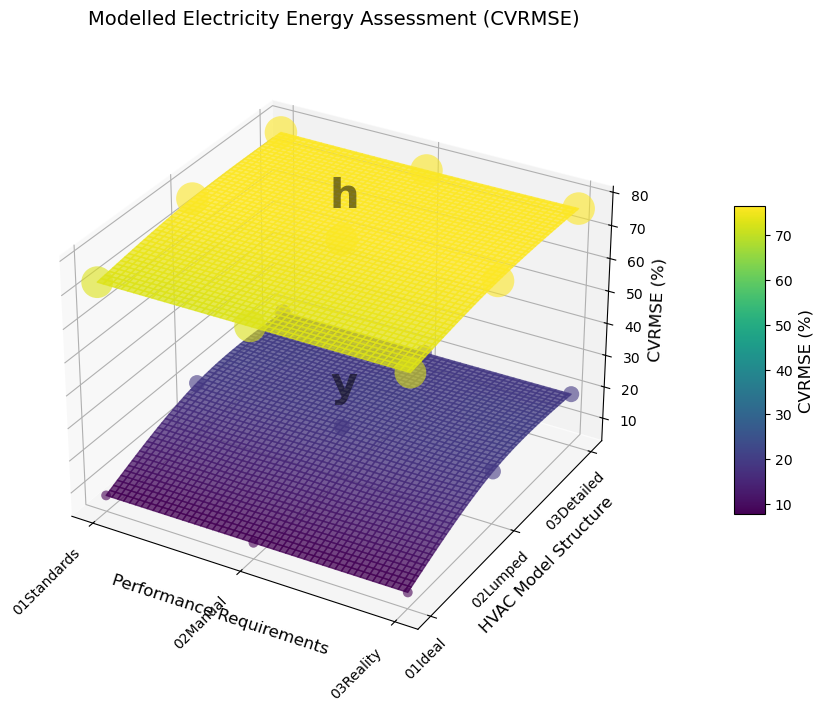

C:\Users\s2589602\AppData\Local\Temp\ipykernel_17328\1937382841.py:306: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


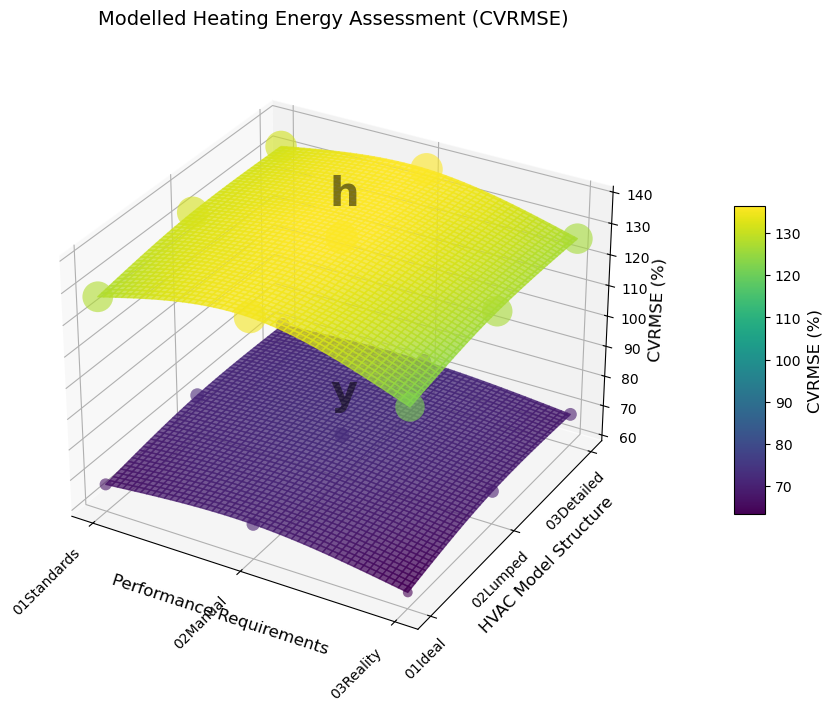

C:\Users\s2589602\AppData\Local\Temp\ipykernel_17328\1937382841.py:306: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


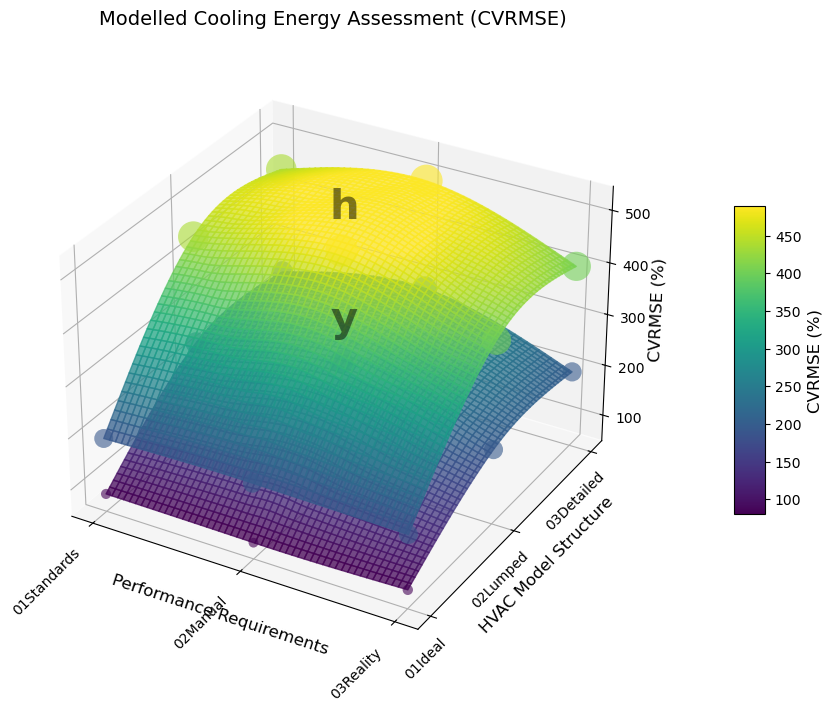

In [25]:
def breakdown_multifrequency_metrics(parent_folders, metered_csv, start_date, end_date, area, 
                                       simulation_name_map=None, print_metric="CVRMSE", 
                                       export_dir=None, verbose=True):
    import os
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    printer = print if verbose else lambda *args, **kwargs: None

    if export_dir:
        os.makedirs(export_dir, exist_ok=True)

    def compute_rmse(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return np.sqrt(mean_squared_error(resampled[met_col], resampled[sim_col]))

    def compute_cvrmse(df, freq_rule, sim_col, met_col):
        rmse = compute_rmse(df, freq_rule, sim_col, met_col)
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (rmse / mean_met) * 100

    def compute_mae(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        if resampled.empty:
            return None
        return mean_absolute_error(resampled[met_col], resampled[sim_col])

    def compute_mape(df, freq_rule, sim_col, met_col):
        # Resample and sum the data
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        
        # Drop rows where `met_col` is 0 or NA
        resampled = resampled.dropna(subset=[met_col])  # Remove NA
        resampled = resampled[resampled[met_col] != 0]  # Remove zeros
        
        # Check if the filtered DataFrame is empty
        if resampled.empty:
            return None
        
        # Compute MAPE
        errors = np.abs((resampled[met_col] - resampled[sim_col]) / resampled[met_col])
        return np.mean(errors) * 100
    
    def compute_nmbe(df, freq_rule, sim_col, met_col):
        resampled = df[[sim_col, met_col]].resample(freq_rule).sum()
        mean_met = resampled[met_col].mean()
        if resampled.empty or mean_met == 0:
            return None
        return (resampled[sim_col] - resampled[met_col]).mean() / mean_met * 100

    sim_start, sim_end = pd.to_datetime(start_date), pd.to_datetime(end_date)

    df_met = process_metering_data(metered_csv, verbose)
    df_met['Timestamp'] = pd.to_datetime(df_met['Timestamp'])
    df_met = df_met[(df_met['Timestamp'] >= sim_start) & (df_met['Timestamp'] < sim_end)]
    df_met.sort_values('Timestamp', inplace=True)
    for metric in ['Electricity', 'Heating', 'Cooling']:
        df_met[f'{metric}_norm'] = df_met[f'Main {metric}'] / area
    df_met.set_index('Timestamp', inplace=True)

    freq_map = {'y':'Y','m':'M','w':'W','d':'D','h':'h'}

    metric_funcs = {'RMSE':compute_rmse,'CVRMSE':compute_cvrmse,'MAE':compute_mae,'MAPE':compute_mape,'NMBE':compute_nmbe}
    metric_dfs = {metric:[] for metric in metric_funcs}

    for folder in parent_folders:
        for sim in os.listdir(folder):
            sim_path = os.path.join(folder, sim, 'eplusmtr.csv')
            if os.path.exists(sim_path):
                df_sim = process_energy_data(sim_path, verbose)
                df_sim['Date/Time'] = pd.to_datetime(df_sim['Date/Time'])
                df_sim = df_sim[(df_sim['Date/Time'] >= sim_start) & (df_sim['Date/Time'] < sim_end)]

                df_sim['Electricity_norm'] = (
                    df_sim['Electricity:Facility [J](Hourly)'] -
                    df_sim.get('Heating:Electricity [J](Hourly)',0)-
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Heating_norm'] = (
                    df_sim['DistrictHeatingWater:Facility [J](Hourly)'] +
                    df_sim.get('Heating:Electricity [J](Hourly)',0)
                )/(area*3.6e6)
                df_sim['Cooling_norm'] = (
                    df_sim['DistrictCooling:Facility [J](Hourly)'] +
                    df_sim.get('Cooling:Electricity [J](Hourly)',0)
                )/(area*3.6e6)

                merged = pd.merge(df_sim, df_met,left_on='Date/Time',right_index=True,suffixes=('_sim','_met'))
                merged.index = merged['Date/Time']
                sim_name = remap_simulation_name(sim, simulation_name_map)

                for metric, func in metric_funcs.items():
                    result_row = {'Simulation':sim_name}
                    for freq_label, freq_rule in freq_map.items():
                        for var in ['Electricity','Heating','Cooling']:
                            col_label = f'EUI$_{{{var}|{freq_label}}}$'
                            result_row[col_label] = func(merged,freq_rule,f'{var}_norm_sim',f'{var}_norm_met')
                    metric_dfs[metric].append(result_row)

    result_dfs = {}
    for metric, rows in metric_dfs.items():
        df = pd.DataFrame(rows).set_index('Simulation').round(2)
        result_dfs[metric] = df
        if metric.upper()==print_metric.upper():
            printer(f"\nComputed {metric.upper()} at multiple frequencies:", list(df.columns))

    return (result_dfs['CVRMSE'], result_dfs['RMSE'], result_dfs['MAE'], result_dfs['MAPE'], result_dfs['NMBE'])

parent_folders = ['2025-Apr15']
metered_csv = 'Metering.csv'
start_date = '2023-01-01'
end_date = '2024-01-01'
area = 8894


simulation_name_map = {
    "gh-Detailed-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_03Detailed",
    "gh-Detailed-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_03Detailed",
    "gh-Detailed-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_03Detailed",
    "gh-Ideal-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_01Ideal",
    "gh-Ideal-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_01Ideal",
    "gh-Ideal-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_01Ideal",
    "gh-Lumped-HVAC": "Performance-Requirements_02Manual | HVAC-Model-Structure_02Lumped",
    "gh-Lumped-HVAC_mod": "Performance-Requirements_01Standards | HVAC-Model-Structure_02Lumped",
    "gh-Lumped-HVAC_mod2": "Performance-Requirements_03Reality | HVAC-Model-Structure_02Lumped",
} 

export_dir = "./exported_metrics"
multifreq_cvrmse_df, multifreq_rmse_df, multifreq_mae_df, multifreq_mape_df, multifreq_nmbe_df = breakdown_multifrequency_metrics(
    parent_folders, 
    metered_csv, 
    start_date, 
    end_date, 
    area, 
    simulation_name_map=simulation_name_map,
    verbose=True,
    export_dir='1'
)

multifreq_cvrmse_df = multifreq_cvrmse_df[sorted(multifreq_cvrmse_df.columns, key=sort_key)]
multifreq_rmse_df= multifreq_rmse_df[sorted(multifreq_rmse_df.columns, key=sort_key)]
multifreq_mape_df= multifreq_mape_df[sorted(multifreq_mape_df.columns, key=sort_key)]
multifreq_mae_df= multifreq_mae_df[sorted(multifreq_mae_df.columns, key=sort_key)]
multifreq_nmbe_df= multifreq_nmbe_df[sorted(multifreq_nmbe_df.columns, key=sort_key)]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import griddata

def plot_3d_kpi_visualization(kpi_df, simulation_name_map, granularity_filter=None, kpi_name='CVRMSE'):
    # Extract descriptive para1 and para2 values from the simulation name map
    para1_values = []
    para2_values = []
    para1_labels = []
    para2_labels = []
    for sim_name in kpi_df.index:
        descriptive_name = simulation_name_map.get(sim_name, sim_name)
        parts = descriptive_name.split(' | ')
        para1_values.append(parts[0])
        para2_values.append(parts[1])
        para1_labels.append(parts[0].split('_')[-1])
        para2_labels.append(parts[1].split('_')[-1])
    
    # Convert to numerical indices for plotting
    para1_unique = sorted(list(set(para1_values)))
    para2_unique = sorted(list(set(para2_values)))
    para1_label = para1_unique[0].split('_')[0].replace('-', ' ')
    para2_label = para2_unique[0].split('_')[0].replace('-', ' ')
    
    para1_map = {val: idx for idx, val in enumerate(para1_unique)}
    para2_map = {val: idx for idx, val in enumerate(para2_unique)}
    x = np.array([para1_map[val] for val in para1_values])
    y = np.array([para2_map[val] for val in para2_values])
    
    # Time granularity order for sorting
    time_order = {'y': 0, 'm': 1, 'w': 2, 'd': 3, 'h': 4}
    
    end_uses = ['Electricity', 'Heating', 'Cooling']
    
    for end_use in end_uses:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title(f"Modelled {end_use} Energy Assessment ({kpi_name})", pad=20, fontsize=14)

        # Identify columns corresponding to the desired end use
        cols = [col for col in kpi_df.columns if f'{{{end_use}|' in col]
        def matches_granularity(col):
            gran = col.split('|')[1].split('}')[0].strip()
            if granularity_filter is None:
                return True
            elif isinstance(granularity_filter, str):
                return gran == granularity_filter
            elif isinstance(granularity_filter, (list, set, tuple)):
                return gran in granularity_filter
            return False

        cols_filtered = [col for col in cols if matches_granularity(col)]
        cols_sorted = sorted(cols_filtered, key=lambda col: time_order[col.split('|')[1].split('}')[0].strip()])
        
        if not cols_sorted:
            print(f"No data for {end_use} at granularity '{granularity_filter}'")
            continue

        # Global normalization for colormap
        all_z_vals = np.concatenate([kpi_df[col].values for col in cols_sorted])
        vmin, vmax = np.min(all_z_vals), np.max(all_z_vals)
        norm = plt.Normalize(vmin, vmax)
        cmap = plt.cm.viridis
        
        # A list to store text label positions and their associated label strings.
        text_positions = []
        
        # Loop over each KPI column to plot points and surfaces.
        for col in cols_sorted:
            metric_part = col.split('{')[1].split('}')[0]
            current_end_use, time_gran = metric_part.split('|')
            time_gran = time_gran.strip()
            z_vals = kpi_df[col].values
            sizes = (z_vals - vmin) / (vmax - vmin + 1e-8) * 500 + 50
            ax.scatter(x, y, z_vals, c=z_vals, cmap=cmap, norm=norm, 
                       s=sizes, alpha=0.6, edgecolors='none')
            
            # Grid calculations
            z_grid = np.zeros((len(para2_unique), len(para1_unique)))
            count_grid = np.zeros_like(z_grid)
            for xi, yi, zi in zip(x, y, z_vals):
                z_grid[yi, xi] += zi
                count_grid[yi, xi] += 1
            z_grid /= np.where(count_grid == 0, 1, count_grid)

            # Create fine grid for interpolation
            fine_points = 100
            x_coarse = np.arange(len(para1_unique))
            y_coarse = np.arange(len(para2_unique))
            xx_coarse, yy_coarse = np.meshgrid(x_coarse, y_coarse)
            fine_x = np.linspace(x_coarse.min(), x_coarse.max(), fine_points)
            fine_y = np.linspace(y_coarse.min(), y_coarse.max(), fine_points)
            xx_fine, yy_fine = np.meshgrid(fine_x, fine_y)
            
            # Interpolate grid data to get a smooth surface
            zz_fine = griddata(
                np.column_stack((xx_coarse.ravel(), yy_coarse.ravel())),
                z_grid.ravel(),
                (xx_fine, yy_fine),
                method='cubic'
            )
            
            # Fill in any NaN values using nearest interpolation
            nan_mask = np.isnan(zz_fine)
            zz_fine[nan_mask] = griddata(
                np.column_stack((xx_coarse.ravel(), yy_coarse.ravel())),
                z_grid.ravel(),
                (xx_fine[nan_mask], yy_fine[nan_mask]),
                method='nearest'
            )

            # Plot the interpolated surface
            facecolors = cmap(norm(zz_fine))
            facecolors[..., 3] = 0.75  # set transparency
            ax.plot_surface(xx_fine, yy_fine, zz_fine,
                            facecolors=facecolors, shade=False)
            
            # Store the center coordinate and the granularity label for later annotation.
            mid_idx = fine_points // 2
            text_positions.append((xx_fine[mid_idx, mid_idx], yy_fine[mid_idx, mid_idx], 
                                   zz_fine[mid_idx, mid_idx], time_gran))
        
        # Now add the text labels after all surfaces have been drawn.
        # Use a vertical offset so that labels appear above the surfaces.
        for tx, ty, tz, label in text_positions:
            z_offset = (vmax - vmin) * 0.1  # 10% of the z-range
            ax.text(tx, ty, tz + z_offset, label, color='black', ha='center', va='bottom',
                    fontsize=30, fontweight='bold', zorder=10, alpha=0.5)
        
        # Axis setup
        ax.set_xlabel(para1_label, labelpad=1, fontsize=12)
        ax.set_ylabel(para2_label, labelpad=1, fontsize=12)
        ax.set_zlabel(f'{kpi_name} (%)', labelpad=1, fontsize=12)

        # Configure tick labels
        ax.set_xticks(np.arange(len(para1_unique)))
        ax.set_xticklabels([val.split('_')[-1] for val in para1_unique], 
                           rotation=45, ha='right', fontsize=10)
        ax.set_yticks(np.arange(len(para2_unique)))
        ax.set_yticklabels([val.split('_')[-1] for val in para2_unique], 
                           rotation=45, ha='right', fontsize=10)

        # Add colorbar for reference
        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.5, aspect=10, pad=0.1)
        cbar.set_label(f'{kpi_name} (%)', fontsize=12)

        # Visual adjustments for the axes
        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')
        ax.grid(True, linestyle='--', alpha=0.25)
        plt.tight_layout()
        plt.show()
        
plot_3d_kpi_visualization(multifreq_cvrmse_df, simulation_name_map, granularity_filter=['h', 'y'],  kpi_name='CVRMSE')

C:\Users\s2589602\AppData\Local\Temp\ipykernel_17328\2507536538.py:306: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


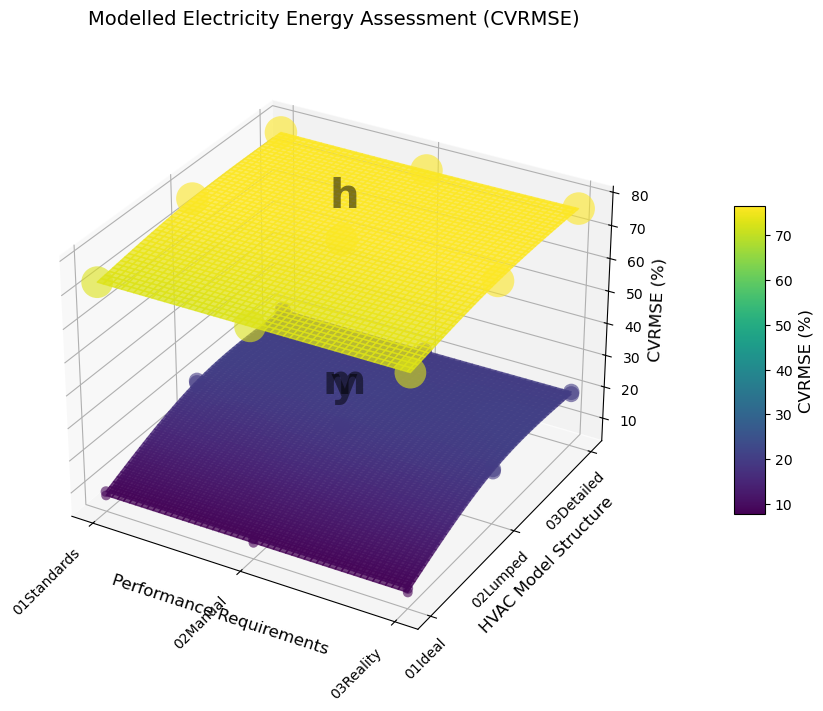

C:\Users\s2589602\AppData\Local\Temp\ipykernel_17328\2507536538.py:306: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


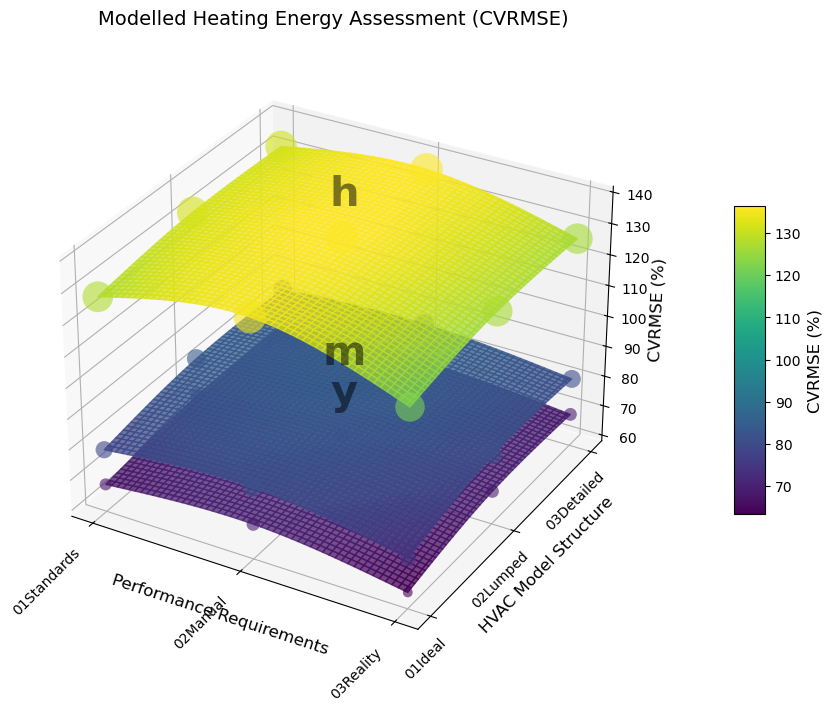

C:\Users\s2589602\AppData\Local\Temp\ipykernel_17328\2507536538.py:306: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


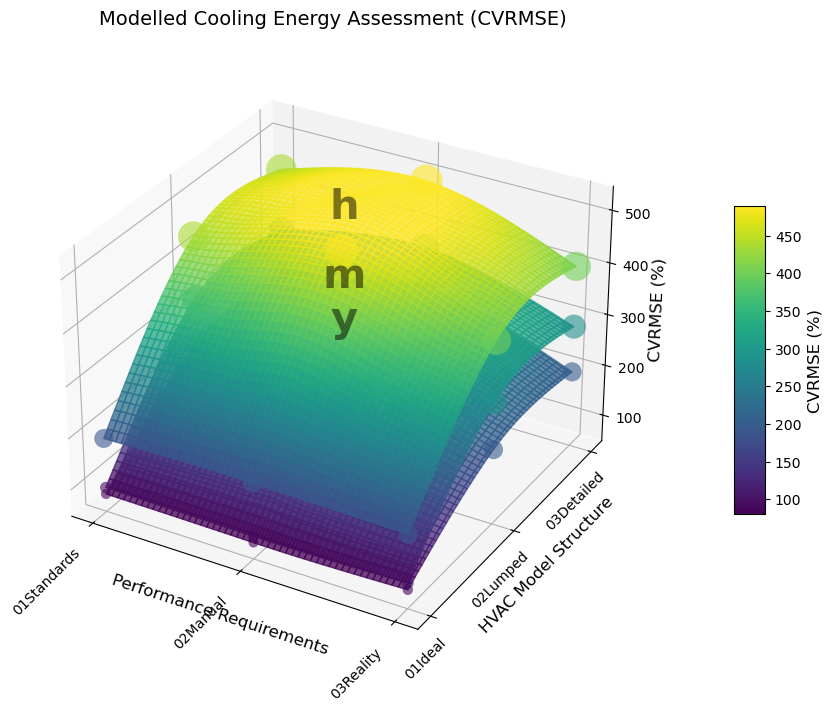

In [24]:
plot_3d_kpi_visualization(multifreq_cvrmse_df, simulation_name_map, granularity_filter=['h', 'm', 'y'],  kpi_name='CVRMSE')